In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, metrics
import numpy as np
from tensorflow.keras import models
from keras.regularizers import l2
from scipy import spatial
%reload_ext autoreload
%autoreload 2
from sklearn.datasets import fetch_lfw_pairs
from sklearn.datasets import fetch_lfw_people
from tensorflow.keras.applications import Xception
from sklearn.model_selection import train_test_split

#!pip install kaggle
#!pip install --upgrade scikit-learn







In [ ]:
"""
import os
import requests
from tqdm import tqdm  # For progress bar

# URL of the dataset
url = "http://vis-www.cs.umass.edu/lfw/"

# Destination directory
dest_dir = "/root/scikit_learn_data/lfw_home/lfw.tgz"
# Destination file path
dest_file = os.path.join(dest_dir, "")

# Create destination directory if it doesn't exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Download the file
response = requests.get(url, stream=True)
total_size_in_bytes = int(response.headers.get('content-length', 0))
block_size = 1024  # 1 Kibibyte

progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
with open(dest_file, 'wb') as file:
    for data in response.iter_content(block_size):
        progress_bar.update(len(data))
        file.write(data)
progress_bar.close()

if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
    print("Error: Failed to download the dataset.")
else:
    print("LFW dataset downloaded successfully.")
"""

'\nimport os\nimport requests\nfrom tqdm import tqdm  # For progress bar\n\n# URL of the dataset\nurl = "http://vis-www.cs.umass.edu/lfw/"\n\n# Destination directory\ndest_dir = "/root/scikit_learn_data/lfw_home/lfw.tgz"\n# Destination file path\ndest_file = os.path.join(dest_dir, "")\n\n# Create destination directory if it doesn\'t exist\nif not os.path.exists(dest_dir):\n    os.makedirs(dest_dir)\n\n# Download the file\nresponse = requests.get(url, stream=True)\ntotal_size_in_bytes = int(response.headers.get(\'content-length\', 0))\nblock_size = 1024  # 1 Kibibyte\n\nprogress_bar = tqdm(total=total_size_in_bytes, unit=\'iB\', unit_scale=True)\nwith open(dest_file, \'wb\') as file:\n    for data in response.iter_content(block_size):\n        progress_bar.update(len(data))\n        file.write(data)\nprogress_bar.close()\n\nif total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:\n    print("Error: Failed to download the dataset.")\nelse:\n    print("LFW dataset downloaded

In [2]:
kaggle_api = {"username":"k213370ahmedmustafa","key":"0fa627b0c7030d201bece7295809fea9"}

import os

os.environ['KAGGLE_USERNAME'] = kaggle_api["username"]
os.environ['KAGGLE_KEY'] = kaggle_api["key"]


In [3]:
import os
from zipfile import ZipFile
from kaggle.api.kaggle_api_extended import KaggleApi


api = KaggleApi()
api.authenticate()


save_dir = "/root/scikit_learn_data/lfw_home"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


api.dataset_download_files("atulanandjha/lfwpeople", path=save_dir, unzip=True)

print("LFW dataset downloaded and extracted successfully.")


Dataset URL: https://www.kaggle.com/datasets/atulanandjha/lfwpeople
LFW dataset downloaded and extracted successfully.


In [4]:
import matplotlib.image as mpimg
lfw_train = fetch_lfw_people(min_faces_per_person=70, resize=0.8,color=True,funneled=True,download_if_missing=False,return_X_y=False)
X_train, X_val, y_train, y_val = train_test_split(lfw_train.images, lfw_train.target, test_size=0.3, random_state=42)
X_train = X_train.astype("float32")
X_val = X_val.astype("float32")


IMG_SHAPE = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
print(IMG_SHAPE)
print(len(y_val))

(100, 75, 3)
387


In [5]:
lfw_pairs_test = fetch_lfw_pairs(subset="test", resize=0.8, color=True)
classes = list(lfw_pairs_test.target_names)
X_test = lfw_pairs_test.pairs
X_test = X_test.astype("float32")
IMG_SHAPE = (X_test[0].shape[1], X_test[0].shape[2], X_test[0].shape[3])
print(IMG_SHAPE)

y_test = lfw_pairs_test.target

(100, 75, 3)


In [6]:
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(tf.abs(anchor - positive)), -1)
        an_distance = tf.reduce_sum(tf.square(tf.abs(anchor - negative)), -1)
        return (ap_distance, an_distance)

class SiameseNetwork():

    def __init__(self,
                 IMG_SHAPE,
                 cnn_filters=[64,64,128],
                 epochs=15,
                 lr=1e-4,
                 batch_size=32,
                 fine_tunning=False,
                 dropout_rate=0.3,
                 embedding_dim=64) -> None:
        self.IMG_SHAPE = IMG_SHAPE
        self.cnn_filters = cnn_filters
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.fine_tunning = fine_tunning
        self.dropout_rate = dropout_rate
        self.embedding_dim = embedding_dim
        self.model = None

    def get_embeddings(self):
      #embedding_model = self._get_embeddings_from_scratch()
        if self.fine_tunning is False:
            #embedding_model = self._get_embeddings_from_scratch()
        else:
            embedding_model = self._get_fine_tunning_embeddings()

        return embedding_model

    def get_siamese_distance_siamese_network(self):
        anchor_input = layers.Input(shape=self.IMG_SHAPE, name='anchor_input')
        positive_input = layers.Input(shape=self.IMG_SHAPE, name='positive_input')
        negative_input = layers.Input(shape=self.IMG_SHAPE, name='negative_input')

        embedding_model = self.get_embeddings()


        anchor_embeddings = embedding_model(anchor_input)
        positive_embeddings = embedding_model(positive_input)
        negative_embeddings = embedding_model(negative_input)

        distances = DistanceLayer()(anchor_embeddings, positive_embeddings, negative_embeddings)

        self.model = models.Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances, name="Embedding")
        return self.model

    def train(self, generator):
        steps_per_epoch = self.batch_size
        history = self.model.fit(generator, steps_per_epoch=steps_per_epoch, batch_size=self.batch_size, epochs=self.epochs)
        return history

    def get_test_model(self, embedding_layer=None):
        if embedding_layer is None:
            embedding_layer = self.model.layers[3]

        anchor_input = tf.keras.Input(shape=self.IMG_SHAPE)
        anchor_embeddings = embedding_layer(anchor_input)
        embedding_model = models.Model(inputs=anchor_input, outputs=anchor_embeddings)
        return embedding_model

    def test(self, X_test, y_test, embedding_layer=None):
        embedding_model = self.get_test_model(embedding_layer)

        embedding1 = embedding_model.predict(np.array(X_test[:, 0]))
        embedding2 = embedding_model.predict(np.array(X_test[:, 1]))

        similarities = []
        for i in range(len(embedding1)):
            similarity = 1 - spatial.distance.cosine(embedding1[i], embedding2[i])
            similarities.append(similarity)

        similarities = np.array(similarities)
        return similarities

    def _get_CNN(self):
        model = models.Sequential(name="CNN")

        for i in range(len(self.cnn_filters)):
            if i == 0:
                model.add(layers.Conv2D(self.cnn_filters[i], (3, 3), input_shape=self.IMG_SHAPE, activation='relu', padding='same', kernel_regularizer=l2(1e-2)))
            else:
                model.add(layers.Conv2D(self.cnn_filters[i], (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-2)))
            model.add(layers.BatchNormalization())
            model.add(layers.MaxPooling2D())
            model.add(layers.Dropout(self.dropout_rate))

        model.add(layers.Flatten())
        model.add(layers.Dense(self.embedding_dim, activation=None))

        return model

    def _get_embeddings_from_scratch(self):
        return self._get_CNN()

    def _get_fine_tunning_embeddings(self):
        input = layers.Input(shape=self.IMG_SHAPE)
\
        pretrained_model = Xception(
            input_shape=self.IMG_SHAPE,
            weights='imagenet',
            include_top=False,
            pooling='avg',
        )

        for i in range(len(pretrained_model.layers)-27):
            pretrained_model.layers[i].trainable = False

        processed = pretrained_model(input)

        flatten = layers.Flatten()(processed)
        x = layers.Dense(512, activation='relu')(flatten)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(self.embedding_dim, activation="relu")(x)
        embeddings = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
        siamese_network = models.Model(inputs=input, outputs=embeddings, name="Embedding")
        return siamese_network



class SiameseModel(models.Model):

    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

In [7]:
def visualize(image0, image1, proba=None):

    plt.imshow(np.concatenate([image0, image1], axis=1), cmap='gray')
    if proba is not None:
        plt.suptitle("Distance: {:.2f}".format(proba))
    plt.show()


def triplet_data_generator(X, y, image_shape, max_size=None):
    total_size = max_size if max_size is not None else max(y)
    triplets = np.zeros((3, total_size, image_shape[0], image_shape[1], 3))
    idx_to_delete = []

    for i in range(total_size):
        idx = i
        anchor_image = X[idx]
        anchor_label = y[idx]

        same_person = np.where(y == anchor_label)[0]
        if len(same_person) > 1:
            idx_i = np.isin(same_person, idx)
            same_person = np.delete(same_person, idx_i)
            positive_index = np.random.choice(same_person)
            negative_index = np.random.choice(np.where(y != anchor_label)[0])
            positive_image = X[positive_index]
            negative_image = X[negative_index]
            #visualize(anchor_image, positive_image)
            #visualize(anchor_image, negative_image)
            triplets[0][i] = anchor_image
            triplets[1][i] = positive_image
            triplets[2][i] = negative_image
        else:
            idx_to_delete.append(i)
        # print("{percentage:.2f}%".format(percentage = (i * 100) / max(y)))

    triplets = np.delete(triplets, idx_to_delete, axis=1)

    tmp = np.array([triplets[0,:], triplets[1,:], triplets[2,:]])
    tmp = np.transpose(tmp, (1, 0, 2, 3, 4))
    return tmp

def get_batch(train_triplet, batch_size):
    num_batches = len(train_triplet) // batch_size

    for i in range(num_batches):
        batch = train_triplet[i * batch_size : (i + 1) * batch_size]
        anchor_imgs = batch[:, 0]
        positive_imgs = batch[:, 1]
        negative_imgs = batch[:, 2]
        targets = np.zeros(batch_size)
        yield [anchor_imgs, positive_imgs, negative_imgs], targets

In [8]:
def visualize(image0, image1, image2):

    plt.imshow(np.concatenate([image0, image1, image2], axis=1))
    plt.title("Anchor/Positive/Negative")
    plt.show()

def visualize_pair(image0, image1, similarity, label):

    plt.imshow(np.concatenate([image0, image1], axis=1))
    title = "Same person" if label == 1 else "Not same person"
    plt.title(title)
    if similarity is not None:
        plt.suptitle("Similarity: {:.2f}".format(similarity))

    plt.show()

def plot_training_loss(loss,val_loss):
    plt.plot(loss, label='training loss')
    plt.plot(val_loss,label='validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    plt.show()


In [9]:
train_data = triplet_data_generator(X_train, y_train, IMG_SHAPE, 500)

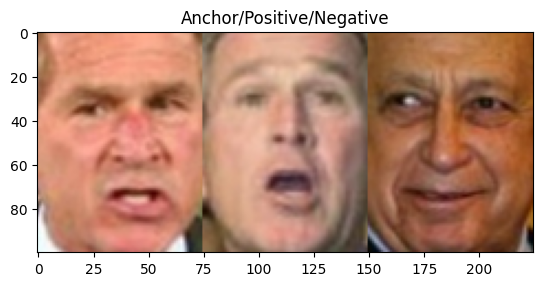

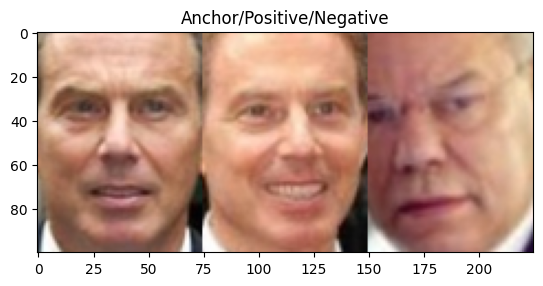

In [10]:
visualize(train_data[0][0], train_data[0][1], train_data[0][2])
visualize(train_data[1][0], train_data[1][1], train_data[1][2])

In [50]:
batch_size = 128
epochs = 10
lr = 1e-3
triplet_loss_margin = 1
fine_tunning = True
embedding_dim = 256

## Unused
dropout_rate = 0.25
cnn_filters = [64, 64, 128]
##


sn = SiameseNetwork(IMG_SHAPE, cnn_filters, epochs, lr, batch_size, fine_tunning, dropout_rate, embedding_dim)
distances_model = sn.get_siamese_distance_siamese_network()
embedding_layer = distances_model.layers[3]


siamese_model = SiameseModel(distances_model, margin=triplet_loss_margin)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

#tf.keras.utils.plot_model(distances_model, show_shapes=True, to_file="images/architecture.png", show_layer_names=True)


In [51]:
loss_history = []
val_loss_history = []
for i in range(epochs):

    print("=================")
    print("Epoch", i)
    epoch_loss = []
    epoch_val_loss = []
    for batch, _ in get_batch(train_data, batch_size):
        loss = siamese_model.train_on_batch(batch)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    loss_history.append(epoch_loss)
    val_data = triplet_data_generator(X_val, y_val, IMG_SHAPE, 200)
    for val_batch,_ in get_batch(val_data,batch_size):
      val_loss = siamese_model.test_on_batch(val_batch)
      epoch_val_loss.append(val_loss)
    epoch_val_loss = sum(epoch_val_loss)/len(epoch_val_loss)
    val_loss_history.append(epoch_val_loss)
    print("Training Loss: ", epoch_loss)
    print("Validation Loss: ", epoch_val_loss)
    print("=================\n")

Epoch 0
Training Loss:  0.9528902371724447
Validation Loss:  0.7080663442611694

Epoch 1
Training Loss:  0.7429672876993815
Validation Loss:  0.6647732257843018

Epoch 2
Training Loss:  0.46784500281016034
Validation Loss:  0.43241775035858154

Epoch 3
Training Loss:  0.37505030632019043
Validation Loss:  0.4330906569957733

Epoch 4
Training Loss:  0.3112867971261342
Validation Loss:  0.372120201587677

Epoch 5
Training Loss:  0.1972146580616633
Validation Loss:  0.28471583127975464

Epoch 6
Training Loss:  0.15865508218606314
Validation Loss:  0.2771586775779724

Epoch 7
Training Loss:  0.11370226740837097
Validation Loss:  0.24928885698318481

Epoch 8
Training Loss:  0.0830974355340004
Validation Loss:  0.2679530382156372

Epoch 9
Training Loss:  0.04705391079187393
Validation Loss:  0.22102105617523193



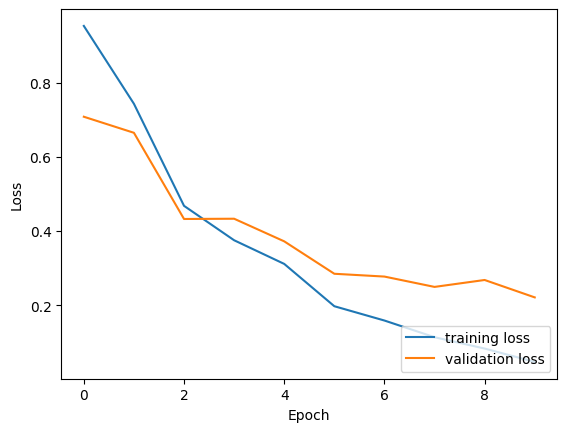

In [52]:
plot_training_loss(loss_history,val_loss_history)


In [32]:
embedding_layer.save_weights('embedding_layer.h5')

In [48]:
# Load model

sn_new = SiameseNetwork(IMG_SHAPE, cnn_filters, epochs, lr, batch_size, True, dropout_rate, embedding_dim)
distances_model_new = sn_new.get_siamese_distance_siamese_network()
embedding_layer_new = distances_model_new.layers[3]


embedding_layer_new.load_weights('embedding_layer.h5')

(100, 75, 3)


In [53]:
from tensorflow.keras import models
from scipy import spatial

def get_test_model(embedding_layer, IMG_SHAPE):
    anchor_input = tf.keras.Input(shape=IMG_SHAPE)
    anchor_embeddings = embedding_layer(anchor_input)
    embedding_model = models.Model(inputs=anchor_input, outputs=anchor_embeddings)
    return embedding_model

def test(X_test, embedding_layer, IMG_SHAPE):
    embedding_model = get_test_model(embedding_layer, IMG_SHAPE)

    embedding1 = embedding_model.predict(np.array(X_test[:, 0]))
    embedding2 = embedding_model.predict(np.array(X_test[:, 1]))

    similarities = []
    for i in range(len(embedding1)):
        similarity = 1 - spatial.distance.cosine(embedding1[i], embedding2[i])
        similarities.append(similarity)

    similarities = np.array(similarities)
    return similarities

In [54]:
similarities = test(X_test, embedding_layer, IMG_SHAPE)

32/32 [==============================] - 1s 19ms/step


In [55]:

not_same_people_idxs = similarities[y_test == 0]
same_people_idxs = similarities[y_test == 1]

avg_for_not_same_people = np.mean(not_same_people_idxs)
avg_for_same_people = np.mean(same_people_idxs)

classes = list(lfw_pairs_test.target_names)
print(classes[0], "(similarity mean)", avg_for_not_same_people)
print(classes[1], "(similarity mean)", avg_for_same_people)

threshold = (avg_for_not_same_people + avg_for_same_people) / 2
print("Threshold:", threshold)

binary_classification = np.zeros_like(similarities)
binary_classification[similarities >= threshold] = 1

accuracy = np.mean(binary_classification == y_test)
print("Accuracy:", accuracy)

Different persons (similarity mean) 0.48976066636619364
Same person (similarity mean) 0.6706420242944733
Threshold: 0.5802013453303334
Accuracy: 0.626


Above 0.5802013453303334 we consider the model classifying as same person


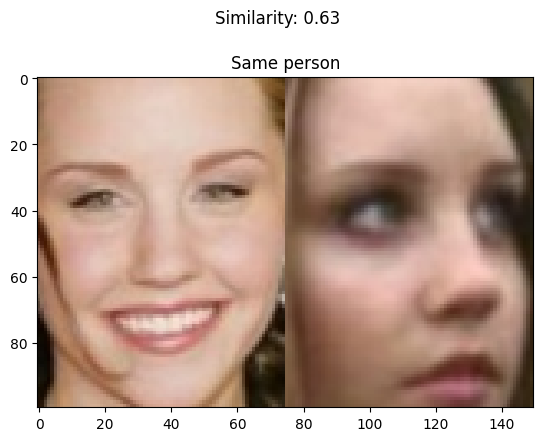

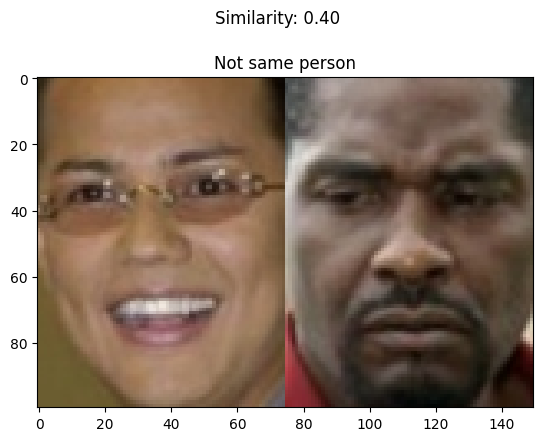

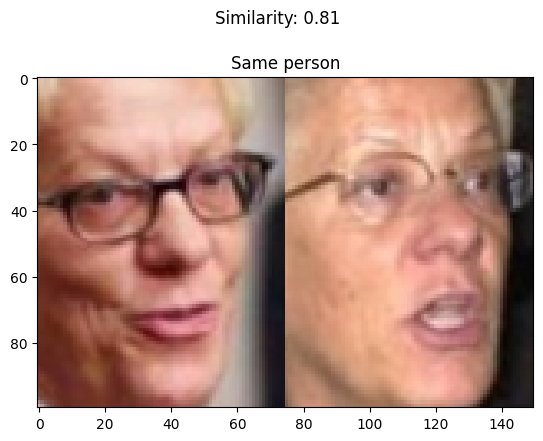

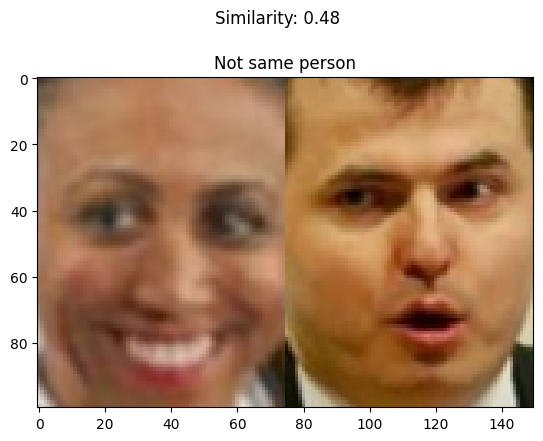

In [63]:
print("Above", threshold, "we consider the model classifying as same person")
visualize_pair(X_test[20][0], X_test[20][1], similarities[20], y_test[20])
visualize_pair(X_test[650][0], X_test[650][1], similarities[650], y_test[650])
i = 67
j=651
visualize_pair(X_test[i][0], X_test[i][1], similarities[i], y_test[i])
visualize_pair(X_test[j][0], X_test[j][1], similarities[j], y_test[j])


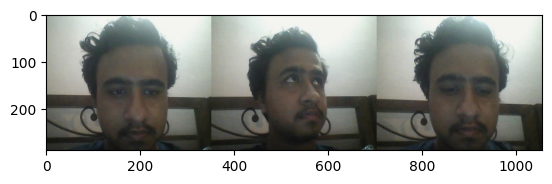

In [57]:
import cv2

webcam1 = cv2.imread('1.jpg')
webcam2 = cv2.imread('2.jpg')
webcam3 = cv2.imread('3.jpg')

# to RGB
webcam1 = cv2.cvtColor(webcam1, cv2.COLOR_BGR2RGB)
webcam2 = cv2.cvtColor(webcam2, cv2.COLOR_BGR2RGB)
webcam3 = cv2.cvtColor(webcam3, cv2.COLOR_BGR2RGB)
plt.imshow(np.concatenate([webcam1, webcam2, webcam3], axis=1))

Original shape (288, 352, 3)
New shape (100, 75, 3)


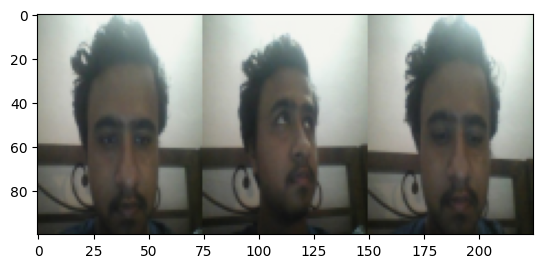

In [58]:
from skimage.transform import resize

print("Original shape", webcam1.shape)

webcam1_resized = resize(webcam1, (100, 75)).astype("float32")
webcam2_resized = resize(webcam2, (100, 75)).astype("float32")
webcam3_resized = resize(webcam3, (100, 75)).astype("float32")
print("New shape", webcam1_resized.shape)
plt.imshow(np.concatenate([webcam1_resized, webcam2_resized, webcam3_resized], axis=1))

In [59]:
def calc_similarity_and_plot(image1, image2, embedding_layer, IMG_SHAPE):
    data = np.array([[image1, image2]])
    similarity = test(data, embedding_layer, IMG_SHAPE)[0]
    label = 1 if similarity > threshold else 0
    visualize_pair(image1, image2, similarity, label)


Above 0.5802013453303334 we consider the model classifying as same person


1/1 [==============================] - 0s 41ms/step


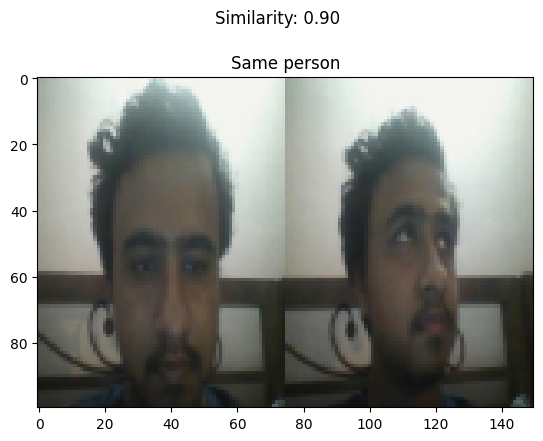

1/1 [==============================] - 0s 22ms/step


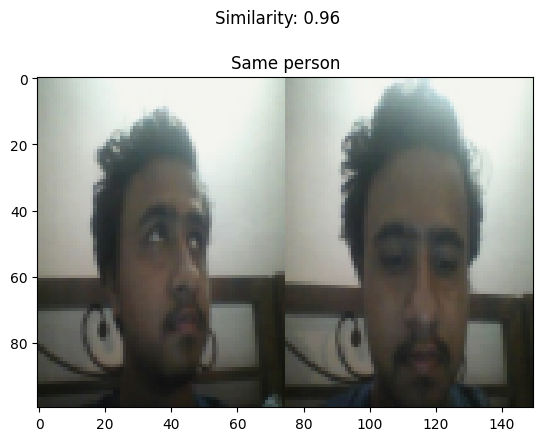

1/1 [==============================] - 0s 24ms/step


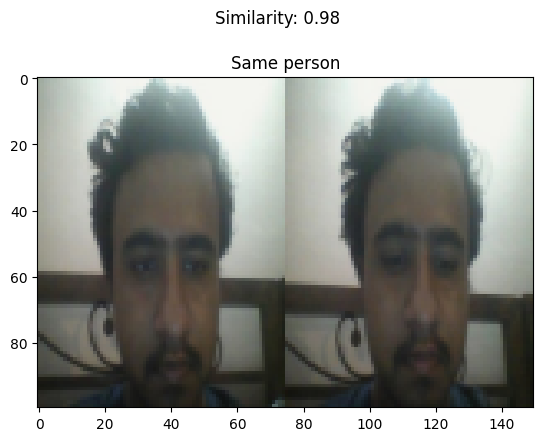

1/1 [==============================] - 0s 22ms/step


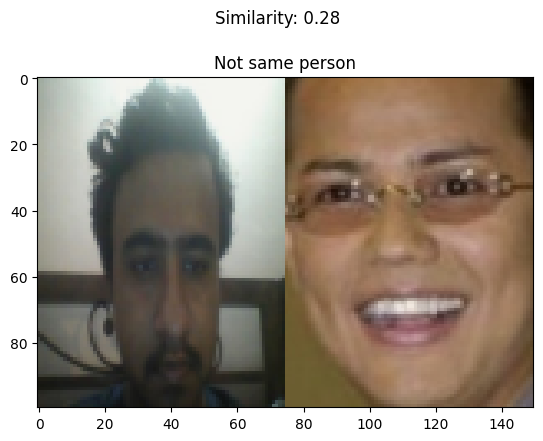

In [61]:
print("Above", threshold, "we consider the model classifying as same person")

calc_similarity_and_plot(webcam1_resized, webcam2_resized, embedding_layer, IMG_SHAPE)
calc_similarity_and_plot(webcam2_resized, webcam3_resized, embedding_layer, IMG_SHAPE)
calc_similarity_and_plot(webcam1_resized, webcam3_resized, embedding_layer, IMG_SHAPE)
calc_similarity_and_plot(webcam1_resized, X_test[650, 0], embedding_layer, IMG_SHAPE)